In [178]:
##  Import Packages
import numpy as np

import pandas as pd
import plotly 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None) # show all of columns


In [179]:
# Load data : Import csv file
df = pd.read_csv('Car_sale_ads.csv')
print(f'shape of data: {df.shape}')
df.head(3)


# create a copy from dataset
df_copy = df.copy()

shape of data: (208304, 25)


In [180]:
# Create consistency in price : Convert PLN to EUR
# Average exchange rate in 2021: 0.2191 EUR.(Google search)

Avg_exchange_rate_2021 = 0.2191

# modify the original DataFrame 
df_copy.loc[df_copy['Currency'] == 'PLN', 'Price'] = (
    df_copy.loc[df_copy['Currency'] == 'PLN', 'Price'] * Avg_exchange_rate_2021
)

/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_54297/4018092414.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[18886.42  9530.85  9837.59 ...  1511.79  1248.87  2607.29]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[df_copy['Currency'] == 'PLN', 'Price'] = (


In [181]:
df_copy.describe()

,Index,Price,Production_year,Mileage_km,Power_HP,Displacement_cm3,CO2_emissions,Doors_number
count,"208,304.00","208,304.00","208,304.00","207,321.00","207,661.00","206,338.00","94,047.00","206,817.00"
mean,"104,151.50","13,871.93","2,012.10","150,276.76",151.84,"1,882.57","319,156.38",4.64
std,"60,132.33","19,479.03",7.00,"2,937,446.81",77.68,729.61,"72,913,958.71",0.77
min,0.00,128.17,"1,915.00",1.00,1.00,400.00,1.00,1.00
25%,"52,075.75","3,899.98","2,008.00","53,000.00",105.00,"1,461.00",120.00,5.00
50%,"104,151.50","7,843.78","2,013.00","144,566.00",136.00,"1,798.00",140.00,5.00
75%,"156,227.25","16,651.60","2,017.00","206,000.00",172.00,"1,997.00",164.00,5.00
max,"208,303.00","1,533,480.90","2,021.00","1,111,111,111.00","1,398.00","8,400.00","20,000,000,000.00",55.00


In [182]:
#Count of ouliers using using IQR method¶

def count_outliers(data,col):
        q1 = data[col].quantile(0.25,interpolation='nearest')
        q2 = data[col].quantile(0.5,interpolation='nearest')
        q3 = data[col].quantile(0.75,interpolation='nearest')
        q4 = data[col].quantile(1,interpolation='nearest')
        IQR = q3 -q1
        global LLP
        global ULP
        LLP = q1 - 1.5*IQR
        ULP = q3 + 1.5*IQR
        if data[col].min() > LLP and data[col].max() < ULP:
            print("No outliers in",i)
        else:
            print("There are outliers in",i)
            x = data[data[col]<LLP][col].size
            y = data[data[col]>ULP][col].size
            a.append(i)
            print('Count of outliers are:',x+y)
global a
a = []
features = df_copy.select_dtypes(exclude='O').columns
for i in features:
    count_outliers(df_copy,i)

No outliers in Index
There are outliers in Price
Count of outliers are: 16600
There are outliers in Production_year
Count of outliers are: 2740
There are outliers in Mileage_km
Count of outliers are: 599
There are outliers in Power_HP
Count of outliers are: 14090
There are outliers in Displacement_cm3
Count of outliers are: 21276
There are outliers in CO2_emissions
Count of outliers are: 4672
There are outliers in Doors_number
Count of outliers are: 48003


In [183]:
# Create a function to print description of each feature
def freq_table(data,feature):
    
    # Calculate the count of each unique value
    count_feature = data[feature].value_counts()

    # Calculate the percentage of each unique value
    percent_count = round(data[feature].value_counts(normalize =True)*100,2)

    # Combine the counts and percentages into a single DataFrame
    table = pd.concat([count_feature,percent_count],axis=1)
    table.columns = ['Count' , 'Percentage %']
    return table

# Create a function to give us description and frequency table of each variable
objetc_feature = df_copy.select_dtypes(include='O')
# Add frequency table only for object variables
for  feature in objetc_feature:
    print(f'Description of {feature}:\n{(df_copy[feature]).describe()}' )
    print(f'Frequency Table\n{freq_table(df_copy,feature)} ')
    print('*'*50)


Description of Currency:
count     208304
unique         2
top          PLN
freq      208034
Name: Currency, dtype: object
Frequency Table
           Count  Percentage %
Currency                      
PLN       208034         99.87
EUR          270          0.13 
**************************************************
Description of Condition:
count     208304
unique         2
top         Used
freq      182850
Name: Condition, dtype: object
Frequency Table
            Count  Percentage %
Condition                      
Used       182850         87.78
New         25454         12.22 
**************************************************
Description of Vehicle_brand:
count         208304
unique           108
top       Volkswagen
freq           18455
Name: Vehicle_brand, dtype: object
Frequency Table
               Count  Percentage %
Vehicle_brand                     
Volkswagen     18455          8.86
BMW            16983          8.15
Audi           16730          8.03
Opel           16322    

In [184]:
# Checking Missing Values with Counts and Percentages
missing_values = df_copy.isna().sum()
missing_percentages = round((missing_values / df_copy.shape[0]) * 100,2)

# Combine counts and percentages into a DataFrame
missing_info = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentages
})

print(missing_info)

                         Missing Count  Missing Percentage
Index                                0                0.00
Price                                0                0.00
Currency                             0                0.00
Condition                            0                0.00
Vehicle_brand                        0                0.00
Vehicle_model                        0                0.00
Vehicle_version                  70222               33.71
Vehicle_generation               60444               29.02
Production_year                      0                0.00
Mileage_km                         983                0.47
Power_HP                           643                0.31
Displacement_cm3                  1966                0.94
Fuel_type                            0                0.00
CO2_emissions                   114257               54.85
Drive                            15076                7.24
Transmission                       479                0.

In [185]:
# Mileage for New vehicles is typically much lower or even one, compared to Used vehicles. Filling missing values globally (using the overall median) might overestimate or underestimate the mileage for certain categories.
# Fill missing values in Mileage_km based on Condition-specific medians

# Calculate medians for Mileage_km grouped by Condition
mileage_medians = df_copy.groupby("Condition")["Mileage_km"].median()

# Fill missing Mileage_km values with the median of their respective Condition group
df_copy["Mileage_km"] = df_copy["Mileage_km"].fillna(
    df_copy["Condition"].map(mileage_medians)
)
# Verify if there are still missing values in Mileage_km
missing_check = df_copy["Mileage_km"].isnull().sum()
print(f"Missing values in Mileage_km after imputation: {missing_check}")


Missing values in Mileage_km after imputation: 0


In [186]:
# List of columns where missing values need to be handled with Median
median_imput_col = ['Power_HP','Displacement_cm3','Doors_number']

# Loop through each column in the list
for col in median_imput_col:
    df_copy[col] = df_copy[col].fillna(df_copy[col].median()) # Fill missing values in the column with the Median


for col in median_imput_col:
    # Count the remaining missing values (if any) in the current column
    missing_check = df_copy[col].isnull().sum()

    # Print the count of missing values after the imputation process
    print(f"Missing values in {col} after imputation: {missing_check}")


Missing values in Power_HP after imputation: 0
Missing values in Displacement_cm3 after imputation: 0
Missing values in Doors_number after imputation: 0


In [187]:
# List of columns where missing values need to be handled with Mode

mode_imput_col = ['Transmission','Origin_country','Drive']

# Loop through each column in the list
for col in mode_imput_col:
    df_copy[col] = df_copy[col].fillna(df_copy[col].mode()[0]) # Fill missing values in the column with the Mode


for col in mode_imput_col:
    # Count the remaining missing values (if any) in the current column
    missing_check = df_copy[col].isnull().sum()

    # Print the count of missing values after the imputation process
    print(f"Missing values in {col} after imputation: {missing_check}")


Missing values in Transmission after imputation: 0
Missing values in Origin_country after imputation: 0
Missing values in Drive after imputation: 0


In [189]:
# Define a function to combine categories with frequency < threshold into "other"
def combine_low_frequency_categories(df, column, threshold=11.0):
    # Calculate value counts as percentages
    value_counts = df[column].value_counts(normalize=True)*100
    
    # Replace categories with frequencies < threshold with 'Other'
    df[column] = df[column].apply(lambda x: x if value_counts[x] >= threshold else 'other')

# List of columns to process
columns_to_modify = ['Fuel_type', 'Type', 'Colour','Vehicle_brand','Origin_country']

# Apply the function to each column
for col in columns_to_modify:
    combine_low_frequency_categories(df_copy, col, threshold=5.0)

# Check the updated columns
for col in columns_to_modify:
    print(f"Updated frequencies for {col}:\n")
    print(df_copy[col].value_counts(normalize=True) * 100)
    print("\n")


Updated frequencies for Fuel_type:

Fuel_type
Gasoline   47.70
Diesel     44.37
other       7.94
Name: proportion, dtype: float64


Updated frequencies for Type:

Type
SUV             19.96
station_wagon   19.31
sedan           15.97
compact         15.43
city_cars       11.57
minivan         10.62
other            7.13
Name: proportion, dtype: float64


Updated frequencies for Colour:

Colour
black    24.17
other    20.70
gray     15.28
silver   14.83
white    14.60
blue     10.42
Name: proportion, dtype: float64


Updated frequencies for Vehicle_brand:

Vehicle_brand
other           48.46
Volkswagen       8.86
BMW              8.15
Audi             8.03
Opel             7.84
Ford             7.68
Mercedes-Benz    5.84
Renault          5.14
Name: proportion, dtype: float64


Updated frequencies for Origin_country:

Origin_country
Poland    70.63
Germany   18.32
other     11.05
Name: proportion, dtype: float64




In [190]:
# Create a new column 'Has_features' to indicate whether the 'Features' column contains data
# If the value in the 'Features' column is an empty list represented as a string ("[]"), assign 0
# Otherwise, assign 1

df_copy["Has_features"] = df_copy["Features"].apply(lambda x: 0 if x == "[]" else 1)
df_copy = df_copy.drop('Features',axis=1)


In [192]:
# Dropping unnecessary columns for clustering.
# Columns to drop: 'CO2_emissions', 'First_owner', 'First_registration_date', 'Offer_publication_date', 'Index'

df_cleaned = df_copy[['Index', 'Price','Condition', 'Vehicle_brand','Production_year', 'Mileage_km', 'Power_HP', 'Displacement_cm3',
       'Fuel_type','Drive', 'Transmission', 'Type',
       'Doors_number', 'Colour', 'Origin_country','Has_features' ]]
df_cleaned.shape

(208304, 16)

In [193]:
# One-hot encoding

def one_hot_encode_with_feature_names(df, one_hot_enc_ft=None):
    if one_hot_enc_ft is None:
        one_hot_enc_ft = ['Condition', 'Fuel_type', 'Transmission', 'Type', 'Colour', 'Has_features','Vehicle_brand','Origin_country','Drive']
    
    if set(one_hot_enc_ft).issubset(df.columns):
        # Function to perform one-hot encoding
        def one_hot_enc(df, one_hot_enc_ft):
            one_hot_enc = OneHotEncoder(sparse_output=False)  # Ensure the result is a dense array
            one_hot_enc.fit(df[one_hot_enc_ft])
            feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
            encoded_array = one_hot_enc.transform(df[one_hot_enc_ft])
            df_encoded = pd.DataFrame(encoded_array, columns=feat_names_one_hot_enc, index=df.index)
            return df_encoded
        
        # Function to concatenate one-hot encoded features with the rest
        def concat_with_rest(df, one_hot_enc_df, one_hot_enc_ft):
            rest_of_features = [ft for ft in df.columns if ft not in one_hot_enc_ft]
            df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]], axis=1)
            return df_concat
        
        # Apply the one-hot encoding and concatenate
        one_hot_enc_df = one_hot_enc(df, one_hot_enc_ft)
        full_df_one_hot_enc = concat_with_rest(df, one_hot_enc_df, one_hot_enc_ft)
        return full_df_one_hot_enc
    
    else:
        print("One or more specified features are not in the dataframe")
        return df
df_encoded = one_hot_encode_with_feature_names(df_cleaned)


In [194]:
df_encoded.shape

(208304, 45)

<Axes: >

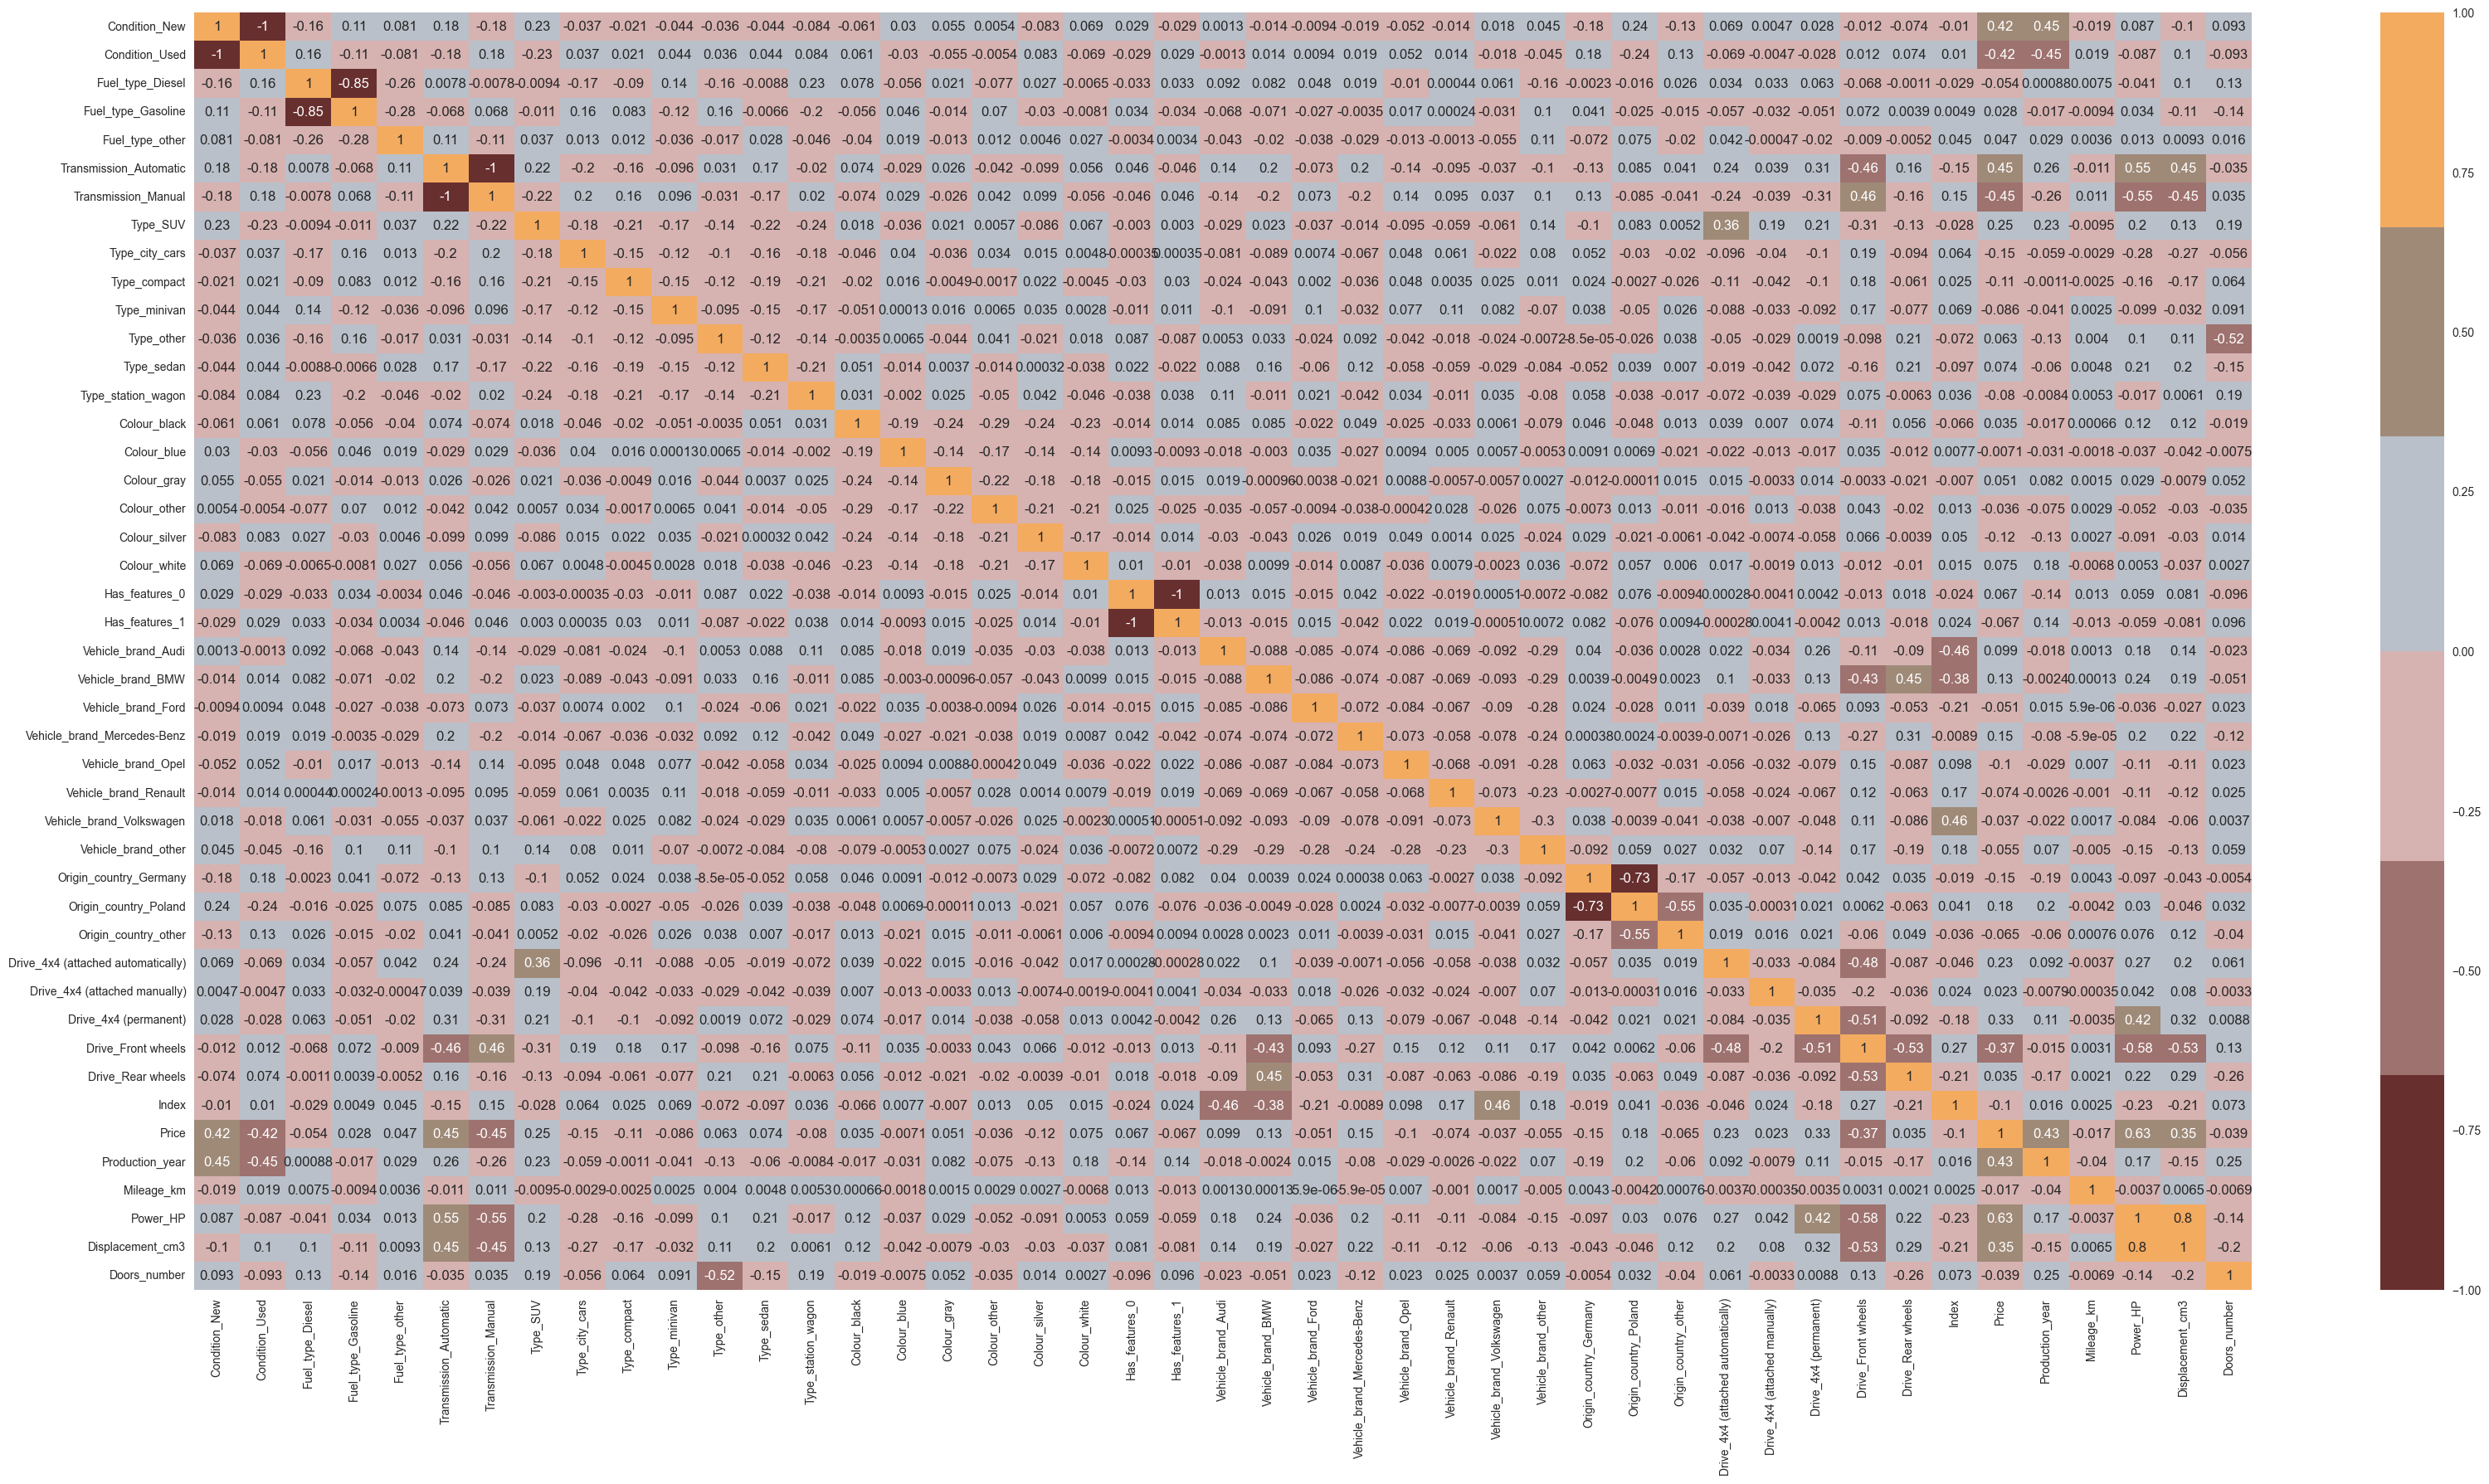

In [195]:
#correlation matrix
from matplotlib import colors

cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
corrmat= df_encoded.corr()
plt.figure(figsize=(40,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

In [196]:
df_encoded=df_encoded.drop(['Fuel_type_Diesel','Origin_country_Germany','Index'],axis=1)

In [197]:
df_encoded.shape

(208304, 42)

In [198]:
# Scaling Numerical Features
columns_to_scale = ['Price','Mileage_km','Power_HP','Displacement_cm3']
scaler = StandardScaler()

# Fit and transform the columns to scale
df_encoded[columns_to_scale] = scaler.fit_transform(df_encoded[columns_to_scale])

In [199]:
df_encoded.shape

(208304, 42)

In [200]:
# Creating a PCA object with 3 components
pca = PCA(n_components=3)

# Fitting and transforming the original data to the new PCA dataframe
data_pca = pca.fit_transform(df_encoded)


# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
cumulative_explained_variance


# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
data_pca = pd.DataFrame(data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])
data_pca

,PC1,PC2,PC3
0,8.87,-0.58,-0.01
1,-38.07,0.11,-0.27
2,5.86,-0.14,-0.02
3,-0.15,-0.46,-0.06
4,8.89,-0.44,-0.02
...,...,...,...
208299,1.77,-0.22,-0.06
208300,-42.05,0.81,-0.28
208301,-35.09,0.43,-0.26
208302,-26.18,0.05,-0.19


In [201]:
cumulative_explained_variance

array([0.85402115, 0.89702573, 0.91429815])

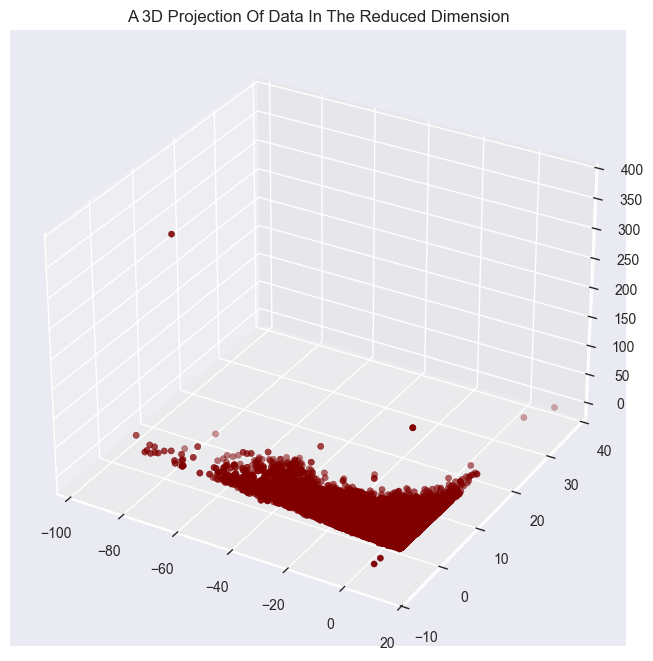

In [202]:
#A 3D Projection Of Data In The Reduced Dimension
x =data_pca["PC1"]
y =data_pca["PC2"]
z =data_pca["PC3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

Elbow Method to determine the number of clusters to be formed:


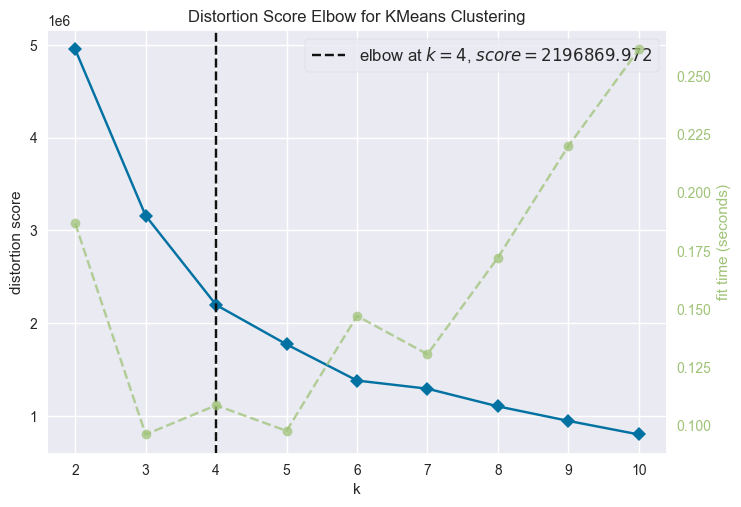

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [203]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(data_pca) # Fit the data to the visualizer
Elbow_M.show()

In [ ]:
# Finding beast number k for K-Means 

sil_scores = []

k_values = range(2, 11) 
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca)
    score = silhouette_score(data_pca, kmeans.labels_)
    sil_scores.append(score)

# print the result
sil_scores

In [205]:
# Develop k-means algorithm
kmeans = KMeans(n_clusters=4)
kmeans.fit(data_pca)

# Getting the cluster labele
data_pca['Cluster_kmeans'] =kmeans.labels_

In [28]:
# Separate the features and the cluster labels
X = data_pca.drop('Cluster_kmeans', axis=1)
clusters = data_pca['Cluster_kmeans']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and value of scores
table_data = [
   
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
metrics_df = pd.DataFrame(table_data, columns=["Metric", "Value"])
metrics_df

,Metric,Value
0,Silhouette Score,0.50
1,Calinski Harabasz Score,"281,814.00"
2,Davies Bouldin Score,0.61


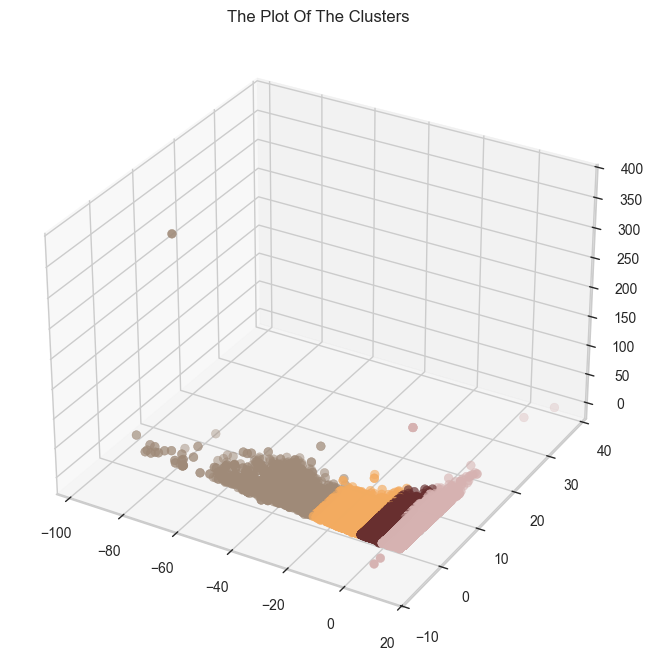

In [29]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=data_pca["Cluster_kmeans"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

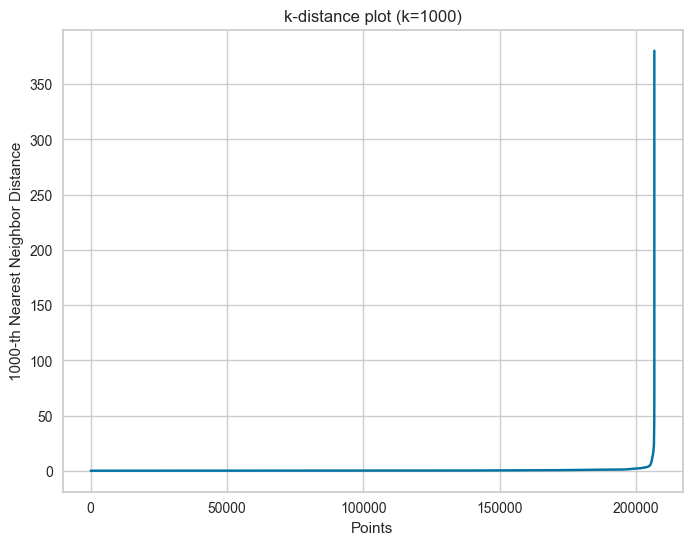

In [31]:
# Appying DBSCAN : finding optimal eps and min_sample
# Replace with your dataset

# Specify the k value (e.g., 4 for 4-nearest neighbors)
k = 1000 

# Fit NearestNeighbors model
neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(X)

# Calculate distances to k-th nearest neighbors for each point
distances, indices = neighbors.kneighbors(X)

# Sort the distances in ascending order
distances = np.sort(distances[:, k-1], axis=0)

# Plot the k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title(f"k-distance plot (k={k})")
plt.xlabel("Points")
plt.ylabel(f"{k}-th Nearest Neighbor Distance")
plt.show()

In [ ]:
#X = data_pca.drop('Cluster_kmeans', axis=1)

# Apply DBSCAN
#dbscan = DBSCAN(eps=2, min_samples=5)
#y_dbscan = dbscan.fit_predict(X)

# Output the cluster labels
#X['A'] = y_dbscan
#X['A'].value_counts()
# Calculate the Silhouette Score using the cluster labels from DBSCAN
# Note: DBSCAN assigns outliers as -1, which needs to be handled when calculating silhouette score
# We can filter out the outliers or set their score to -1 in the silhouette calculation
#sil_score = silhouette_score(X, y_dbscan)

#print(f"Silhouette Score: {sil_score}")


❌The Kernel crashed while executing code in the current cell or a previous cell. 
Please review the code in the cell(s) to identify a possible cause of the failure. 
Click here for more info. 
View Jupyter log for further details.

In [173]:
data_pca.shape

(208304, 4)

In [174]:
df_cleaned.shape

(208304, 16)

In [206]:
data_pca['Cluster_kmeans'] =kmeans.labels_
df_cleaned['Cluster'] = data_pca['Cluster_kmeans'] # concat Cluster to original data
df_encoded['Cluster']= data_pca['Cluster_kmeans'] # concat Cluster to original data

/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_54297/1274838118.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Cluster'] = data_pca['Cluster_kmeans'] # concat Cluster to original data


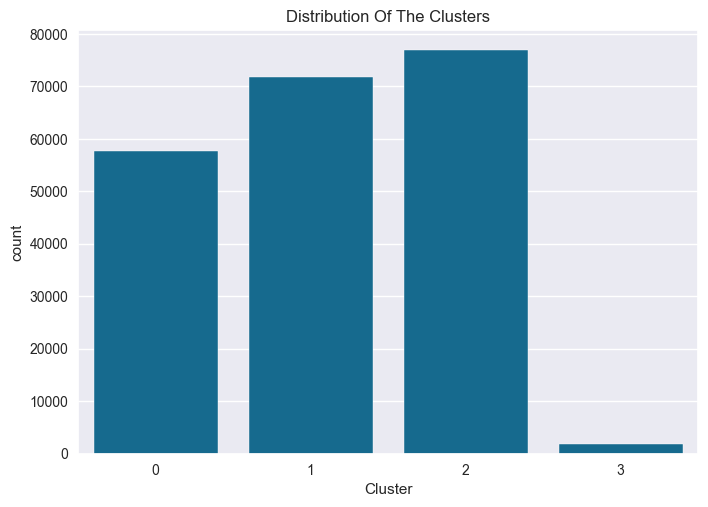

In [207]:
#Plotting countplot of clusters
pl = sns.countplot(x=df_encoded["Cluster"])
pl.set_title("Distribution Of The Clusters")
plt.show()

/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_54297/1952744997.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = df['Cluster'].astype("category")
/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_54297/1952744997.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  b = sns.boxplot(
/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_54297/1952744997.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  b = sns.boxplot(
/var/fol

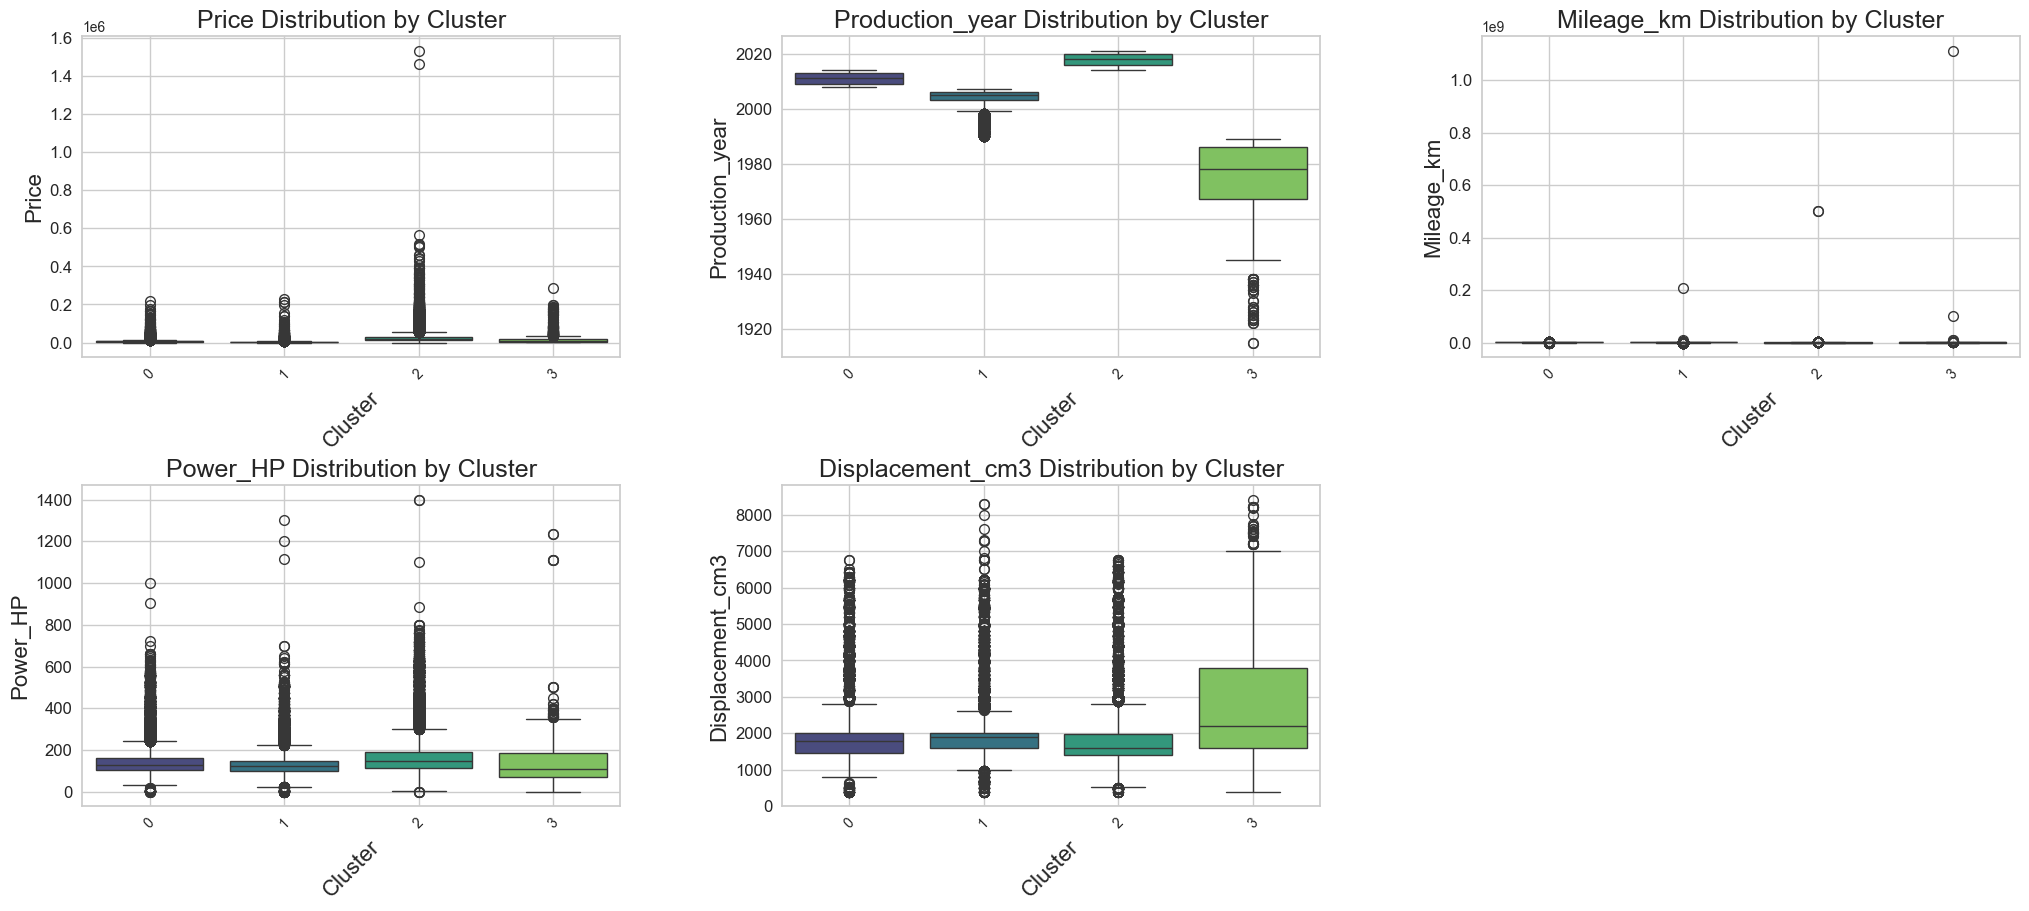

/Users/atefeh/miniconda3/envs/tf2/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


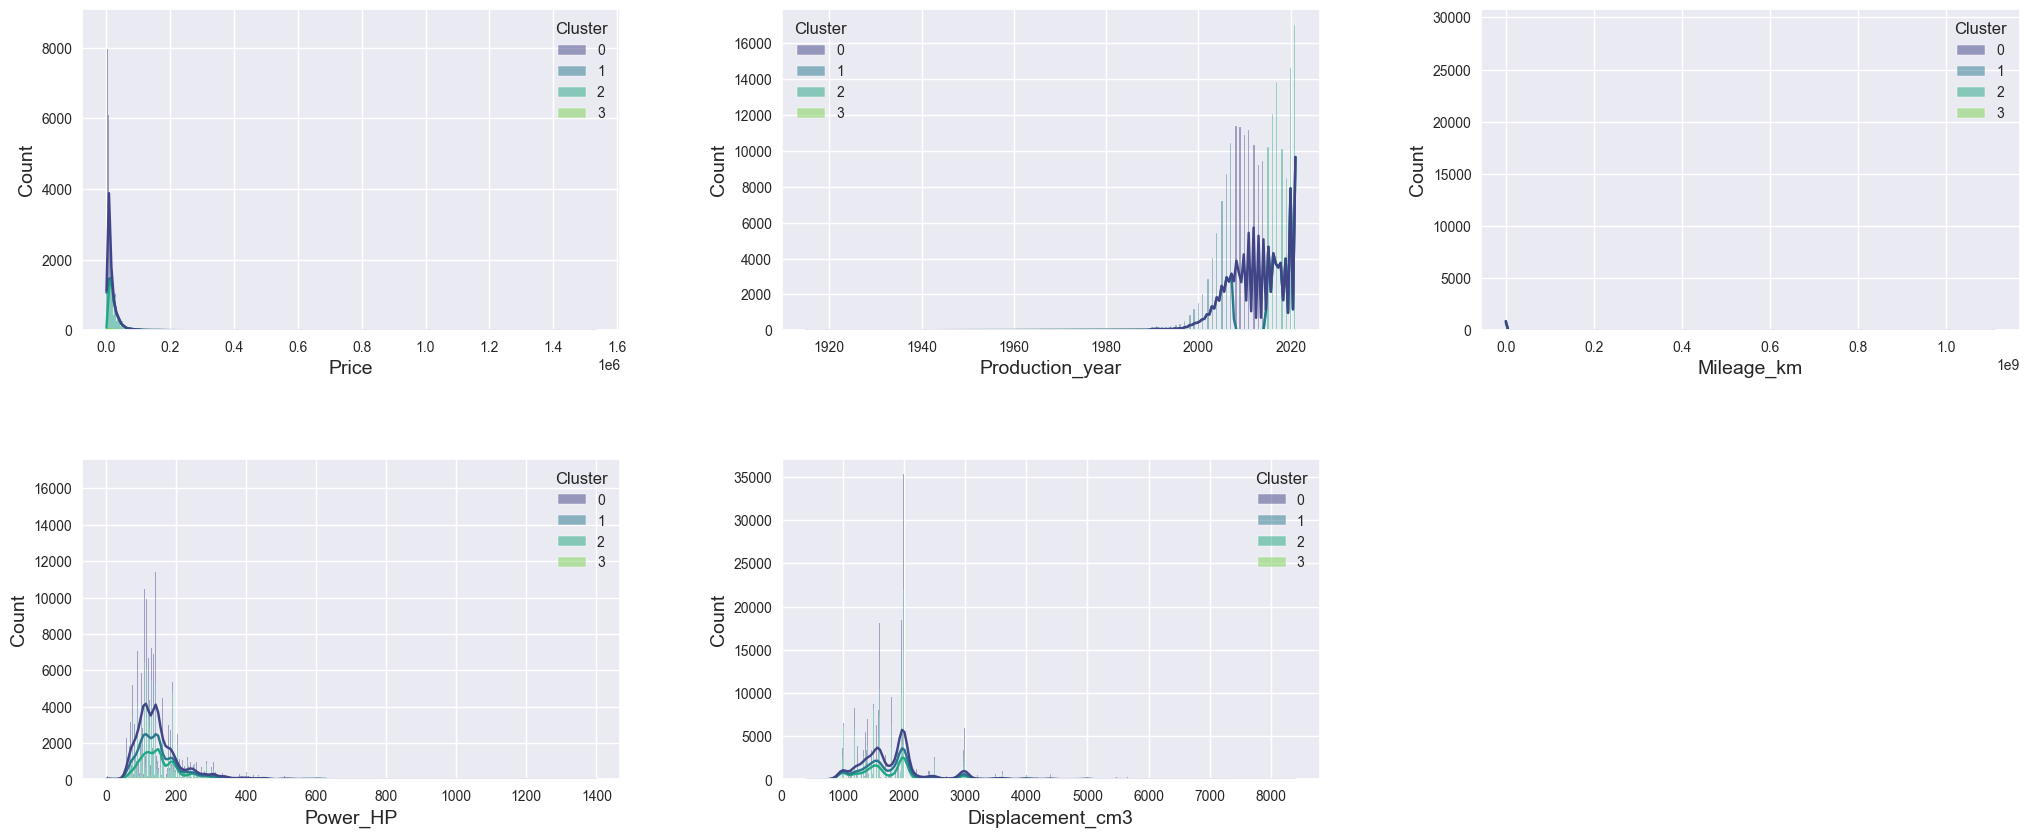

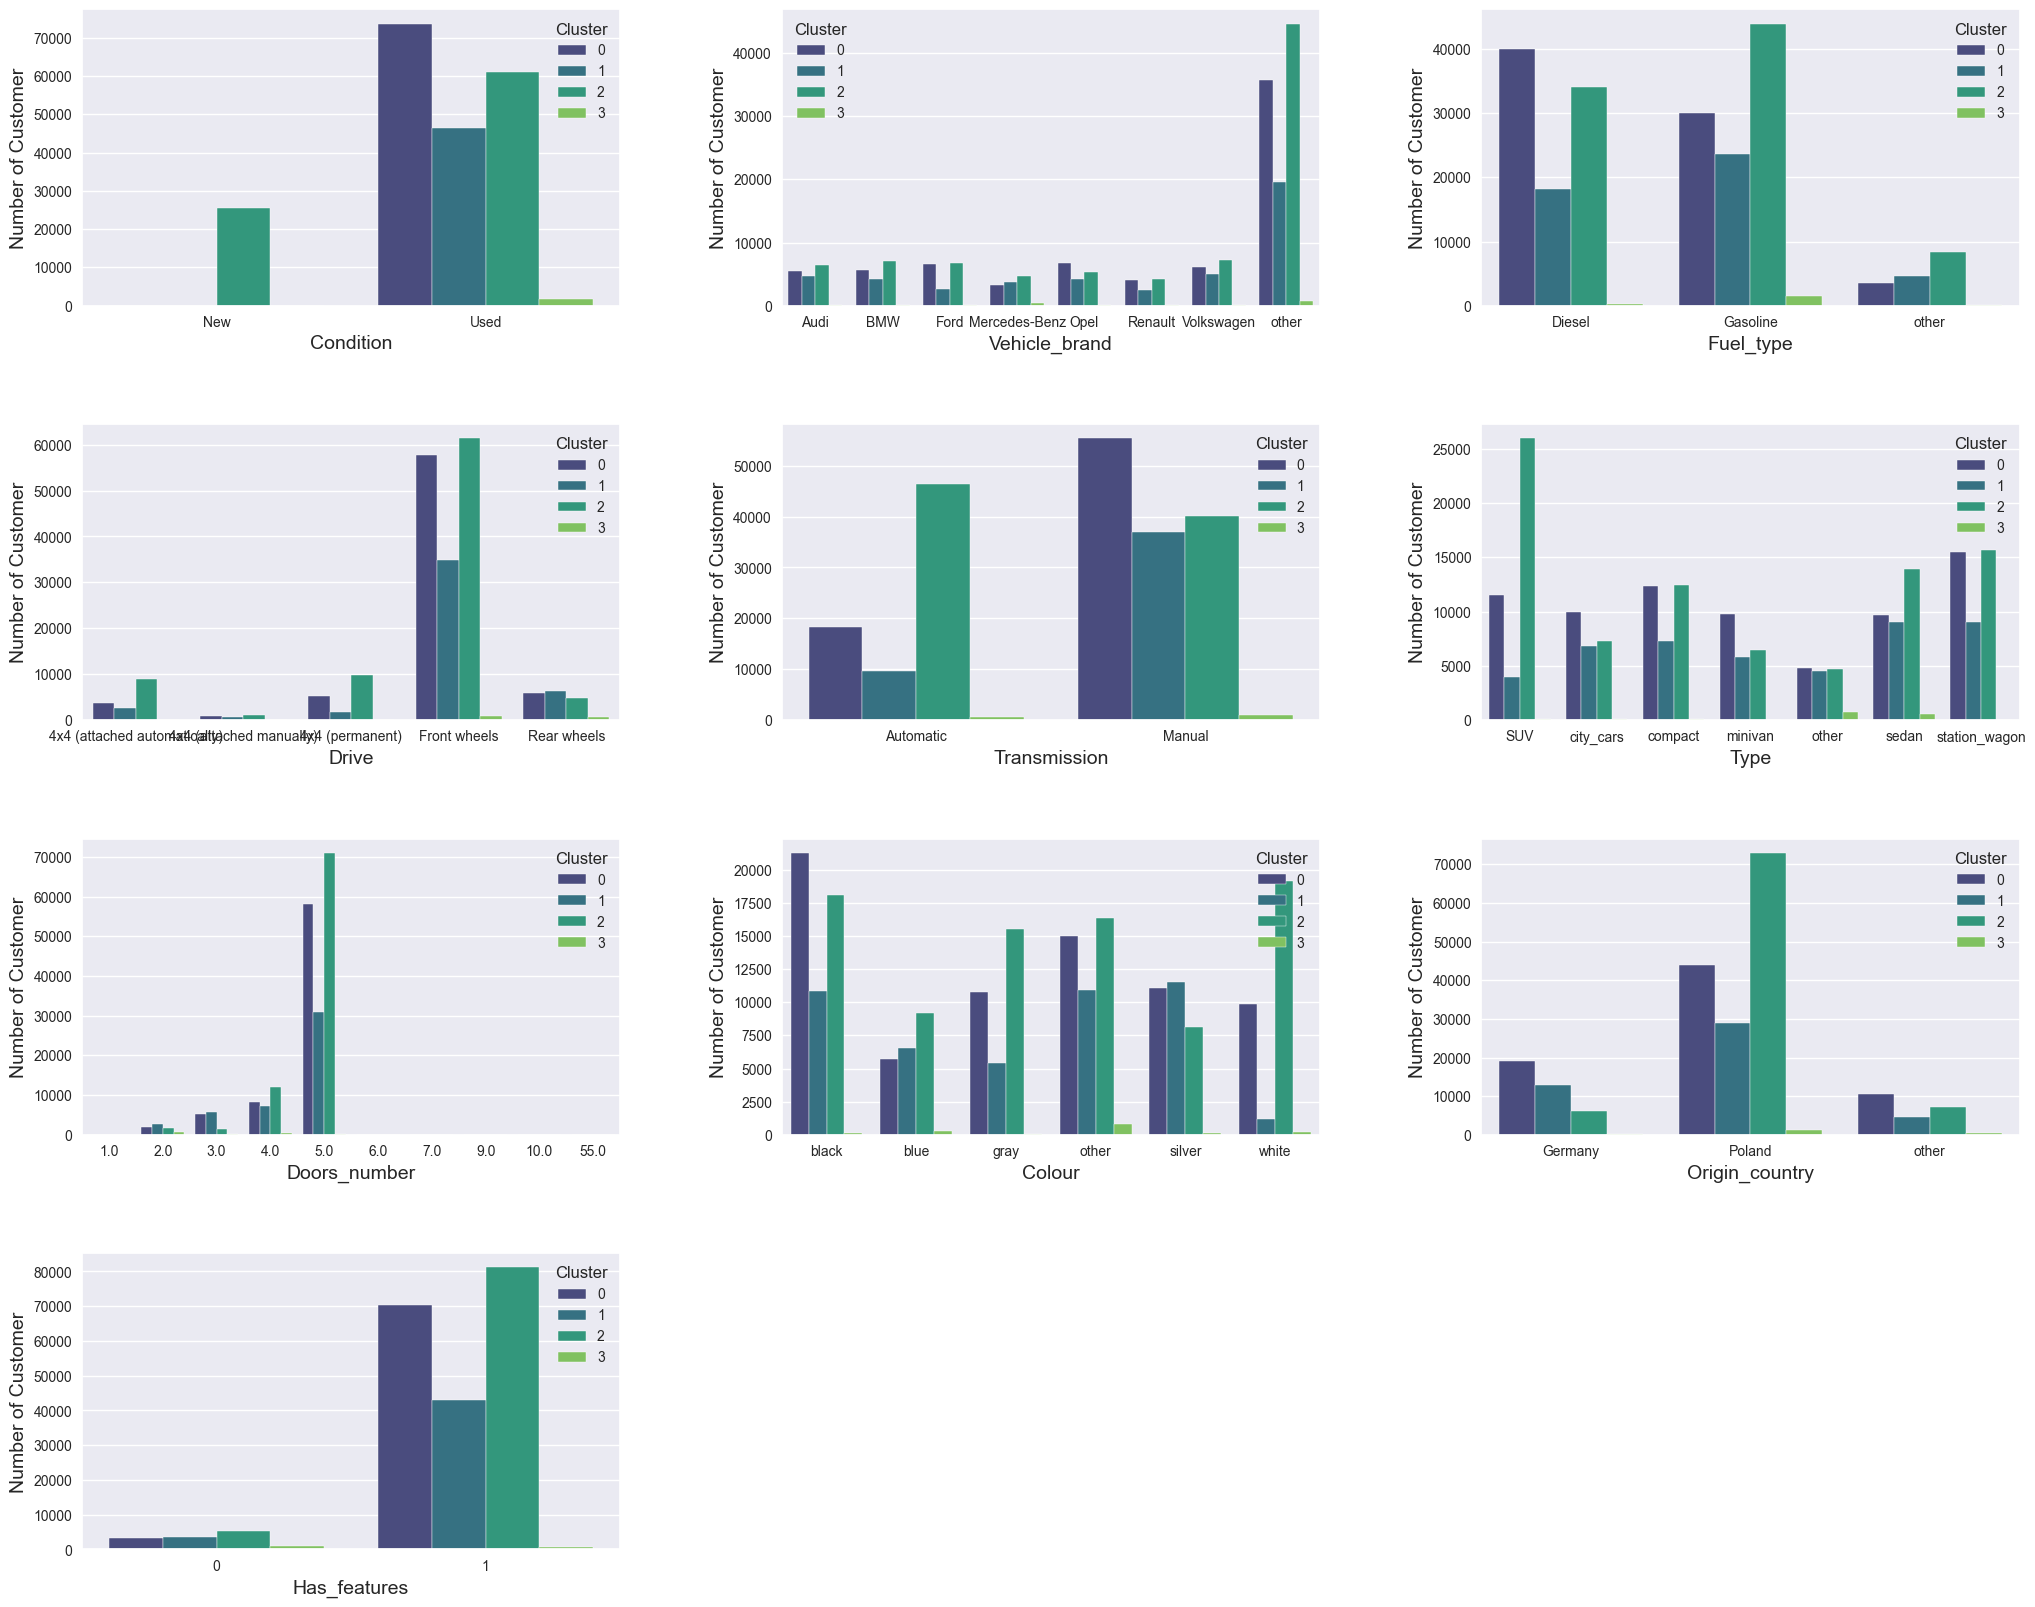

In [69]:

num_cols = ['Price',
       'Production_year', 'Mileage_km', 'Power_HP', 'Displacement_cm3']

object_cols = ['Condition', 'Vehicle_brand', 
        'Fuel_type', 'Drive',
       'Transmission', 'Type', 'Doors_number', 'Colour', 'Origin_country',
       'Has_features']

def graph_builder(df):
    
    
    def boxplot():
        n_cols = len(num_cols)
        rows = (n_cols + 2) // 3  # Calculate the number of rows, rounding up
        _, axes = plt.subplots(ncols=3, nrows=rows, figsize=(25, 5 * rows))
        plt.subplots_adjust(wspace=0.3, hspace=0.4)
        axes = np.ravel(axes)  # Flatten axes array to 1D

        # Ensure the "Cluster" column is categorical
        df['Cluster'] = df['Cluster'].astype("category")

        for num, col in enumerate(num_cols):
            if num < len(axes):  # Ensure index doesn't exceed the number of axes
                b = sns.boxplot(
                    data=df,
                    y=col,
                    x="Cluster",
                    palette="viridis",
                    ax=axes[num]
                )
                axes[num].set_xlabel('Cluster', fontsize=16, rotation=45)
                axes[num].set_ylabel(f'{df[col].name}', fontsize=16)
                axes[num].tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels
                axes[num].tick_params(axis='y', labelsize=12)  # Adjust y-axis label size
                axes[num].set_title(f'{df[col].name} Distribution by Cluster', fontsize=18)
                axes[num].grid(True)  # Add gridlines
                sns.set_style('darkgrid')

        # Hide unused axes if there are any
        for ax in axes[len(num_cols):]:
            ax.set_visible(False)

    
    def histplot():    
        n_cols = len(num_cols)
        rows = (n_cols + 2) // 3  # Adjust row calculation
        _, axes = plt.subplots(ncols=3, nrows=rows, figsize=(25, 5 * rows))
        plt.subplots_adjust(wspace=0.3, hspace=0.4)
        axes = np.ravel(axes)  # Flatten axes array

        for num, col in enumerate(num_cols):
            if num < len(axes):
                h = sns.histplot(
                    data=df,
                    x=col,
                    hue="Cluster",
                    multiple="stack",
                    kde=True,
                    palette="viridis",
                    ax=axes[num]
                )
                h.set_xlabel(f'{df[col].name}', fontsize=14)
                h.set_ylabel('Count', fontsize=14)
                sns.set_style('darkgrid')

        # Hide unused axes
        for ax in axes[len(num_cols):]:
            ax.set_visible(False)
            
    def barplot():
        n_cols = len(object_cols)
        rows = (n_cols + 2) // 3  # Adjust row calculation
        size_cluster = df.groupby("Cluster").count().iloc[:, 0]
        _, axes = plt.subplots(ncols=3, nrows=rows, figsize=(25, 5 * rows))
        plt.subplots_adjust(wspace=0.3, hspace=0.4)
        axes = np.ravel(axes)  # Flatten axes array

        for num, col in enumerate(object_cols):
            if num < len(axes):
                data = df.groupby(["Cluster"])[col].value_counts().unstack(fill_value=0).T
                data = pd.DataFrame(data.unstack())
                data.columns = ["Number of objects"]
                data = data.reset_index()

                b = sns.barplot(
                    data=data,
                    x=col,
                    hue="Cluster",
                    y="Number of objects",
                    ax=axes[num],
                    palette="viridis"
                )
                b.set_xlabel(f'{col}', fontsize=14)
                b.set_ylabel('Number of Customer', fontsize=14)
                sns.set_style('darkgrid')

        # Hide unused axes
        for ax in axes[len(object_cols):]:
            ax.set_visible(False)
    
    # Calling the functions
    boxplot()
    histplot()
    barplot()
    
graph_builder(df_cleaned)


In [208]:
# Analysis Using Groupby
group_offer = df_cleaned.groupby('Cluster').agg({
                                        'Mileage_km':'mean', 
                                        'Displacement_cm3' : 'mean', 
                                        'Price':'mean',
                                        'Power_HP' : 'mean',
                                         'Doors_number':'mean'})



group_offer

,Mileage_km,Displacement_cm3,Price,Power_HP,Doors_number
Cluster,,,,,
0,"223,658.29","1,980.16","3,582.92",135.65,4.46
1,"168,204.90","1,846.06","8,240.18",143.89,4.68
2,"61,109.22","1,819.28","26,822.57",171.73,4.76
3,"781,724.87","2,783.87","15,257.58",133.68,3.23


In [115]:
df_cleaned.groupby(['Cluster','Condition']).agg({'Condition':'count',
                                        'Production_year':'mean',
                                        'Mileage_km':'mean', 
                                        'Displacement_cm3' : 'mean', 
                                        'Price':'mean',
                                        'Power_HP' : 'mean'
                                        })

/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_54297/4114110605.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_cleaned.groupby(['Cluster','Condition']).agg({'Condition':'count',


Condition  Production_year  Mileage_km  Displacement_cm3  \
Cluster Condition                                                             
0       New                0              NaN         NaN               NaN   
        Used           73707         2,010.85  178,803.97          1,861.74   
1       New                0              NaN         NaN               NaN   
        Used           46461         2,004.04  227,777.97          2,001.70   
2       New            25454         2,020.63       97.70          1,685.89   
        Used           60970         2,017.23   97,655.14          1,869.84   
3       New                0              NaN         NaN               NaN   
        Used            1712         1,974.64  839,437.41          2,826.43   

                      Price  Power_HP  
Cluster Condition                      
0       New             NaN       NaN  
        Used       7,258.64    142.35  
1       New             NaN       NaN  
        Used       3,352.60    135.45  
2       New       35,647.46    169.79  
        Used      20,729.52    168.61  
3       New             NaN       NaN  
        Used      16,093.06    134.20

In [125]:
df_cleaned.columns

Index(['Index', 'Price', 'Condition', 'Vehicle_brand', 'Production_year',
       'Mileage_km', 'Power_HP', 'Displacement_cm3', 'Fuel_type', 'Drive',
       'Transmission', 'Type', 'Doors_number', 'Colour', 'Origin_country',
       'Has_features', 'Cluster'],
      dtype='object')

In [ ]:
# Grouping by 'Cluster' and 'Transmission', and counting occurrences
count_data = df_cleaned.groupby(['Cluster', 'Transmission']).agg({'Transmission': 'count'}).rename(columns={'Transmission': 'Count'})

# Resetting index to calculate percentages
count_data = count_data.reset_index()

# Calculating the total count for each 'Cluster'
total_counts = df_cleaned.groupby('Cluster').size().reset_index(name='Total')

# Merging the total counts with the count_data
count_data = count_data.merge(total_counts, on='Cluster')

# Calculating percentage
count_data['Percentage'] = (count_data['Count'] / count_data['Total']) * 100

# Displaying the result
print(count_data[['Cluster', 'Transmission', 'Count', 'Percentage']])


  Cluster Transmission  Count  Percentage
0       0    Automatic  18305       24.83
1       0       Manual  55402       75.17
2       1    Automatic   9576       20.61
3       1       Manual  36885       79.39
4       2    Automatic  46392       53.68
5       2       Manual  40032       46.32
6       3    Automatic    663       38.73
7       3       Manual   1049       61.27


/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_54297/878194284.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_data = df_cleaned.groupby(['Cluster', 'Transmission']).agg({'Transmission': 'count'}).rename(columns={'Transmission': 'Count'})
/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_54297/878194284.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df_cleaned.groupby('Cluster').size().reset_index(name='Total')


In [ ]:
# Grouping by 'Cluster' and 'Transmission', and counting occurrences
count_data = df_cleaned.groupby(['Cluster', 'Type']).agg({'Type': 'count'}).rename(columns={'Type': 'Count'})

# Resetting index to calculate percentages
count_data = count_data.reset_index()

# Calculating the total count for each 'Cluster'
total_counts = df_cleaned.groupby('Cluster').size().reset_index(name='Total')

# Merging the total counts with the count_data
count_data = count_data.merge(total_counts, on='Cluster')

# Calculating percentage
count_data['Percentage'] = (count_data['Count'] / count_data['Total']) * 100

# Displaying the result
print(count_data[['Cluster', 'Type', 'Count', 'Percentage']])


   Cluster           Type  Count  Percentage
0        0            SUV  11534       15.65
1        0      city_cars   9957       13.51
2        0        compact  12349       16.75
3        0        minivan   9765       13.25
4        0          other   4855        6.59
5        0          sedan   9719       13.19
6        0  station_wagon  15528       21.07
7        1            SUV   3985        8.58
8        1      city_cars   6795       14.63
9        1        compact   7312       15.74
10       1        minivan   5832       12.55
11       1          other   4522        9.73
12       1          sedan   9013       19.40
13       1  station_wagon   9002       19.38
14       2            SUV  25977       30.06
15       2      city_cars   7258        8.40
16       2        compact  12422       14.37
17       2        minivan   6469        7.49
18       2          other   4704        5.44
19       2          sedan  13954       16.15
20       2  station_wagon  15640       18.10
21       3

/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_54297/2692287146.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_data = df_cleaned.groupby(['Cluster', 'Type']).agg({'Type': 'count'}).rename(columns={'Type': 'Count'})
/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_54297/2692287146.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df_cleaned.groupby('Cluster').size().reset_index(name='Total')


In [90]:
# Grouping by 'Cluster' and 'Transmission', and counting occurrences
count_data = df_cleaned.groupby(['Cluster', 'Has_features']).agg({'Has_features': 'count'}).rename(columns={'Has_features': 'Count'})

# Resetting index to calculate percentages
count_data = count_data.reset_index()

# Calculating the total count for each 'Cluster'
total_counts = df_cleaned.groupby('Cluster').size().reset_index(name='Total')

# Merging the total counts with the count_data
count_data = count_data.merge(total_counts, on='Cluster')

# Calculating percentage
count_data['Percentage'] = (count_data['Count'] / count_data['Total']) * 100

# Displaying the result
print(count_data[['Cluster', 'Has_features', 'Count', 'Percentage']])


  Cluster  Has_features  Count  Percentage
0       0             0   3402        4.62
1       0             1  70305       95.38
2       1             0   3573        7.69
3       1             1  42888       92.31
4       2             0   5253        6.08
5       2             1  81171       93.92
6       3             0   1109       64.78
7       3             1    603       35.22


/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_54297/611138436.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_data = df_cleaned.groupby(['Cluster', 'Has_features']).agg({'Has_features': 'count'}).rename(columns={'Has_features': 'Count'})
/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_54297/611138436.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df_cleaned.groupby('Cluster').size().reset_index(name='Total')


In [95]:
# Grouping by 'Cluster' and 'Transmission', and counting occurrences
count_data = df_cleaned.groupby(['Cluster', 'Transmission']).agg({'Transmission': 'count'}).rename(columns={'Transmission': 'Count'})

# Resetting index to calculate percentages
count_data = count_data.reset_index()

# Calculating the total count for each 'Cluster'
total_counts = df_cleaned.groupby('Cluster').size().reset_index(name='Total')

# Merging the total counts with the count_data
count_data = count_data.merge(total_counts, on='Cluster')

# Calculating percentage
count_data['Percentage'] = (count_data['Count'] / count_data['Total']) * 100

# Displaying the result
print(count_data[['Cluster', 'Transmission', 'Count', 'Percentage']])


  Cluster Transmission  Count  Percentage
0       0    Automatic  18305       24.83
1       0       Manual  55402       75.17
2       1    Automatic   9576       20.61
3       1       Manual  36885       79.39
4       2    Automatic  46392       53.68
5       2       Manual  40032       46.32
6       3    Automatic    663       38.73
7       3       Manual   1049       61.27


/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_54297/878194284.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_data = df_cleaned.groupby(['Cluster', 'Transmission']).agg({'Transmission': 'count'}).rename(columns={'Transmission': 'Count'})
/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_54297/878194284.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df_cleaned.groupby('Cluster').size().reset_index(name='Total')
